In [0]:
import os
import re
import glob
import datetime
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import multiprocessing
from multiprocessing.dummy import Pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import xgboost as xgb

In [20]:
cpu_count  = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 3


In [0]:
seed=42
np.random.seed(seed)

# Download Dataset

In [73]:
use_colab = True
print('Using Google Colab: {}'.format(use_colab))

if use_colab:

    from googleapiclient.discovery import build
    import io, os
    from googleapiclient.http import MediaIoBaseDownload
    from google.colab import auth

    if not os.path.exists('../input/'):

        auth.authenticate_user()

        drive_service = build('drive', 'v3')
        results = drive_service.files().list(
                q="name = 'kaggle.json'", fields="files(id)").execute()
        kaggle_api_key = results.get('files', [])

        filename = "/content/.kaggle/kaggle.json"
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
        fh = io.FileIO(filename, 'wb')
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print("Download %d%%." % int(status.progress() * 100))
        os.chmod(filename, 600)

        !pip install kaggle
        !kaggle competitions download -c santander-value-prediction-challenge -p ../input/
        !cd ../input && unzip sample_submission.csv.zip && unzip test.csv.zip && unzip train.csv.zip

    else:
        print('Dataset already downloaded!')

Using Google Colab: True
Dataset already downloaded!


In [0]:
path2train = '../input/train.csv'
path2test = '../input/test.csv'

In [0]:
df_train = pd.read_csv(path2train)
df_test = pd.read_csv(path2test)

y = np.log1p(df_train['target'].values)
X = df_train[df_train.columns.drop(['ID','target'])].values

IdTest = df_test['ID'].values
X_test = df_test[df_test.columns.drop(['ID'])].values

In [25]:
df_train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


Text(0.5,1,'log(1 + T)')

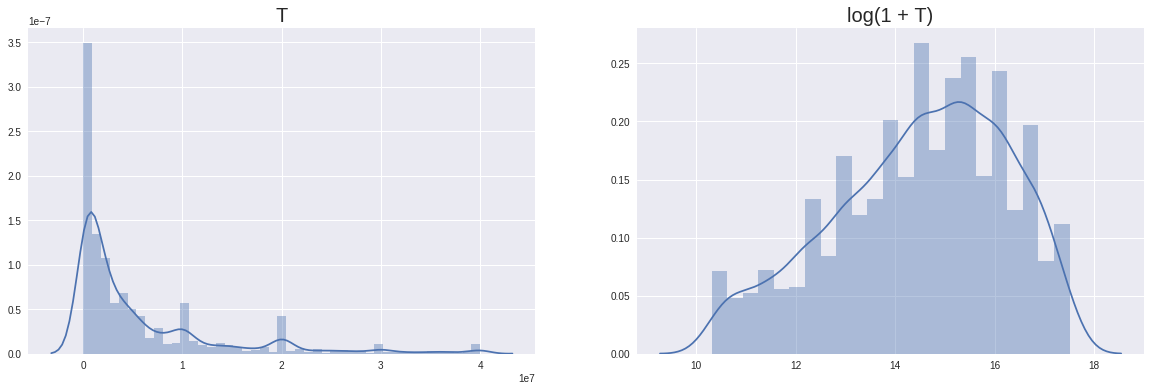

In [26]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.distplot(df_train['target'].values)
plt.title('T', fontsize=20)
plt.subplot(1,2,2)
sns.distplot(y)
plt.title('log(1 + T)', fontsize=20)

In [0]:
def data_corr(data):
    fig = plt.figure(figsize=(10,8))
    correlation = data.corr()
    sns.heatmap(correlation, annot=False, cbar=True, cmap="RdYlGn")

In [0]:
#data_corr(df_train[2:])

**Split dataset**

In [29]:
test_size = 0.2
print('Valid size: {}'.format(test_size))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

Valid size: 0.2


In [30]:
print('X train shape: {}'.format(X_train.shape))
print('y train shape: {}'.format(y_train.shape))

print('X valid shape: {}'.format(X_valid.shape))
print('y valid shape: {}'.format(y_valid.shape))

print('X test shape: {}'.format(X_test.shape))

X train shape: (3567, 4991)
y train shape: (3567,)
X valid shape: (892, 4991)
y valid shape: (892,)
X test shape: (49342, 4991)


**Data Normalization**

In [0]:
normalization_type = 'zScore'

In [32]:
print('Normalization type: {}'.format(normalization_type))

if normalization_type == 'minMax':
    scaler = MinMaxScaler()
    
elif normalization_type == 'zScore':        
    scaler =  StandardScaler()

Normalization type: zScore


In [0]:
## data normalization
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)   

**Define regression model**

In [0]:
boost_params = {'eval_metric': 'rmse'}

model = xgb.XGBRegressor(
    max_depth=10,
    learning_rate=0.01,
    n_estimators=1000,
    objective='reg:linear',
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    scale_pos_weight=1,
    seed=27,
    **boost_params)

In [35]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=1)

In [0]:
def plot_features_importance(cols, importance, most_important = 40):

    df = pd.DataFrame({'cols':cols, 'imp':importance}
                       ).sort_values('imp', ascending=False) 
    
    df[:most_important].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

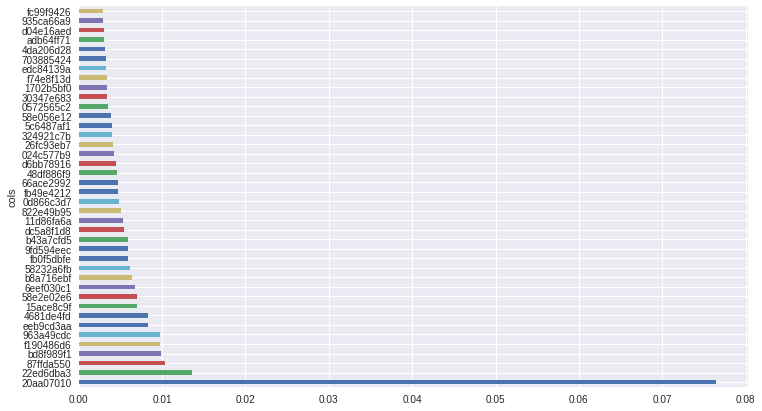

In [63]:
plot_features_importance(df_train.columns[2:], model.feature_importances_)

**Model's evaluation**

In [0]:
#from https://www.kaggle.com/marknagelberg/rmsle-function

def rmsle(y_pred, y):
	assert len(y) == len(y_pred)
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [0]:
def evaluate_regression(ypred, ytrue):
    mse_eval = mse(ypred, ytrue)
    mae_eval = mae(ypred, ytrue)
    rmsle_eval = rmsle(ypred, ytrue)
    
    print('Mean Squared Error: {}'.format(mse_eval))
    print('Mean Absolute Error: {}'.format(mae_eval))
    print('Root Mean Squared Logarithmic Error: {}'.format(rmsle_eval))

In [67]:
ypred_train = model.predict(X_train)
evaluate_regression(ypred_train, y_train)

Mean Squared Error: 0.7388005072359186
Mean Absolute Error: 0.6200120819943928
Root Mean Squared Logarithmic Error: 0.058013800701727375


In [0]:
def generate_submission(ID, ypred):
    
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    sub = pd.DataFrame({'ID': ID})
    sub['target'] = ypred

    sub.to_csv(sub_file, index=False)
    print('Submission File saved: {}'.format(sub_file))

In [0]:
ypred_test = model.predict(X_test)
ypred_test = np.expm1( ypred_test ).astype(np.int)

In [70]:
generate_submission(IdTest, ypred_test)

Submission File saved: subm/submission_2018-07-14-17-04.csv


In [72]:
!kaggle competitions submit -c santander-value-prediction-challenge -f "subm/submission_2018-07-14-17-04.csv" -m "xgboost_2018-07-14-17-04"

Successfully submitted to Santander Value Prediction Challenge